In [1]:
#  %matplotlib widget 
from astropy.io import fits
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import pydl.pydlutils.trace as tr
from astropy.convolution import convolve, Box1DKernel
from glob import glob
import os.path as ptt
from os import getenv
import numpy as np
import pandas as pd
from scipy import signal
from scipy import interpolate
from tqdm.auto import tqdm

In [2]:
flat = Table(dtype=[('expid', int),('tai', float), ('cam', str), ('exptime', float), ('mean',float),('median', float), ('std', float)])
flat['mean'].shape=(0,500)
flat['median'].shape=(0,500)
flat['std'].shape=(0,500)

for i, spFrame in enumerate(tqdm(glob(ptt.join(getenv('BOSS_SPECTRO_REDUX'), 'v6_0_9', '??????', 'spFrame-b?-*')))):
    #if i == 10: break
    try:
        superflat = fits.getdata(spFrame,4)
        xx,superflat = tr.traceset2xy(tr.TraceSet(superflat))

        hdr = fits.getheader(spFrame)
        flatFrame = ptt.join(ptt.dirname(spFrame), hdr['FLATFILE'].replace('sdR', 'spFlat').replace('.fit', '.fits.gz'))
        flathdr = fits.getheader(flatFrame)
        if flathdr['EXPOSURE'] in flat['expid'].data: 
            continue
        fflat = fits.getdata(flatFrame)
        flat.add_row((flathdr['EXPOSURE'], flathdr['TAI-BEG'], flathdr['CAMERAS'], flathdr['EXPTIME'], np.mean((fflat[:,900:3500]*superflat[:,900:3500]), axis=1), np.median((fflat[:,900:3500]*superflat[:,900:3500]), axis=1), np.std((fflat[:,900:3500]*superflat[:,900:3500]), axis=1)))
    except:
        pass
    
    try:
        spFrame = spFrame.replace('spFrame-b', 'spFrame-r')
        superflat = fits.getdata(spFrame,4)
        xx,superflat = tr.traceset2xy(tr.TraceSet(superflat))

        hdr = fits.getheader(spFrame)
        flatFrame = ptt.join(ptt.dirname(spFrame), hdr['FLATFILE'].replace('sdR', 'spFlat').replace('.fit', '.fits.gz'))
        fflat = fits.getdata(flatFrame)
        #pixflat = hdr['PIXFLAT']
        flathdr = fits.getheader(flatFrame)
        flat.add_row((flathdr['EXPOSURE'], flathdr['TAI-BEG'], flathdr['CAMERAS'],flathdr['EXPTIME'], np.mean((fflat[:,450:3500]*superflat[:,450:3500]), axis=1), np.median((fflat[:,450:3500]*superflat[:,450:3500]), axis=1), np.std((fflat[:,450:3500]*superflat[:,450:3500]), axis=1)))
    except:
        pass
    
hdu = fits.BinTableHDU(data=flat)
hdu.writeto('flat_summary.fits',overwrite=True)
    


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [10]:
plt.figure()
flat_r = flat[flat['cam']=='r1']
flat_b = flat[flat['cam']=='b1']
plt.plot(flat_r['tai'].data/(24*3600),flat_r['mean'].data[:,0]/flathdr['EXPTIME']*25, ls='', marker='.', color='r')
plt.plot(flat_b['tai'].data/(24*3600),flat_b['mean'].data[:,0]/flathdr['EXPTIME']*25, ls='', marker='.', color='b')
plt.xlabel('tai')
plt.ylabel('mean flat')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'mean flat')

In [574]:
ff = fits.open("flat_summary_v2.fits")

In [575]:
x = ff[0]

In [576]:
x=ff[1]


In [577]:
x.columns


ColDefs(
    name = 'expid'; format = 'K'
    name = 'tai'; format = 'D'
    name = 'cam'; format = '2A'
    name = 'exptime'; format = 'D'
    name = 'mean'; format = '500D'; dim = '(500)'
    name = 'median'; format = '500D'; dim = '(500)'
    name = 'std'; format = '500D'; dim = '(500)'
)

In [578]:
d = x.data

In [579]:
d.columns['expid']

name = 'expid'; format = 'K'

In [580]:
d.names


['expid', 'tai', 'cam', 'exptime', 'mean', 'median', 'std']

In [581]:
d['expid']

array([320205, 320205, 319320, ..., 353751, 353821, 353821])

In [582]:
tai = d['tai']
xx = np.argsort(tai)
#xx = np.arange(len(expid))
tai = d['tai'][xx]
expid = d['expid'][xx]
mu = d['mean'][xx]
sd = d['std'][xx]

cam = d['cam'][xx]
ok = cam=='r1'

tai = tai[ok]
expid = expid[ok]
mu = mu[ok]
sd = sd[ok]
cam = cam[ok]

In [583]:
cam

chararray(['r1', 'r1', 'r1', ..., 'r1', 'r1', 'r1'],
          dtype='<U2')

In [584]:
from pylab import *

In [585]:
def process(µ):
    res = np.zeros(µ.shape[0])
    denom = np.mean(µ[:,201:250])
    res = µ[:,200]/denom
    return res
    

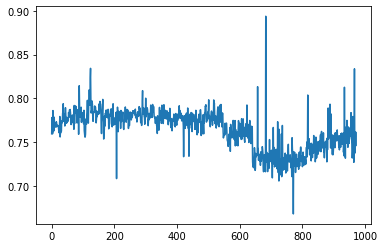

In [586]:
plot(process(mu[1000:]))

# about 2% per ratio, but I want 10x less

In [587]:
def handle(µ, sd, control=5):
    res = np.zeros(µ.shape[0])
    sds = np.zeros_like(res)
    md = np.mean(µ)
    for i in range(µ.shape[0]):        
        ok = (sd[i] > 0) & (sd[i] < 1)
        res[i] = np.mean(µ[i,ok])
        sds[i] = np.nanstd(µ[i,ok])
    return res,sds

sl = (slice(1000,2000,1), slice(200,201))
y1,sd1 = handle(mu[sl], sd[sl])
sl = (slice(1000,2000,1), slice(300,320))
y2,sd2 = handle(mu[sl], sd[sl])

In [588]:
np.std(y1),np.std(y2)

(0.021269163355762306, 0.017144651689702726)

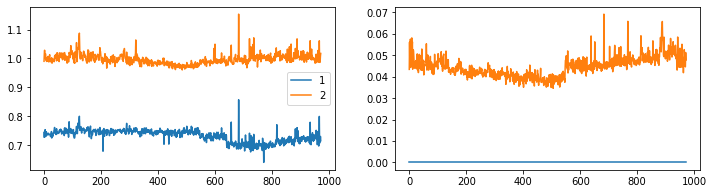

In [589]:
figure(figsize=(12,3))
subplot(1,2,1)
plot(y1)
plot(y2)
legend(["1","2"])
subplot(1,2,2)
plot(sd1)
plot(sd2)

0.023414342184884272

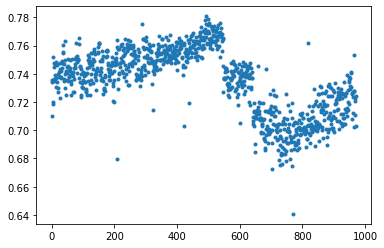

In [590]:
plot(y1/y2,'.')
np.std(y1/y2)

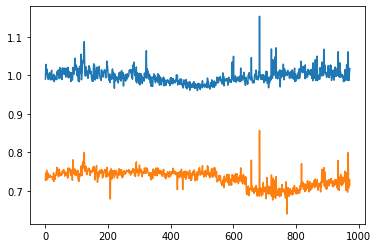

In [591]:
plot(y2)
plot(y1)

In [592]:
expid

array([318675, 318681, 318689, ..., 353768, 353821, 353828])

In [593]:
345762 in expid

True

In [594]:
expid.searchsorted(345762)

1587

In [595]:
expid[1587]

345762

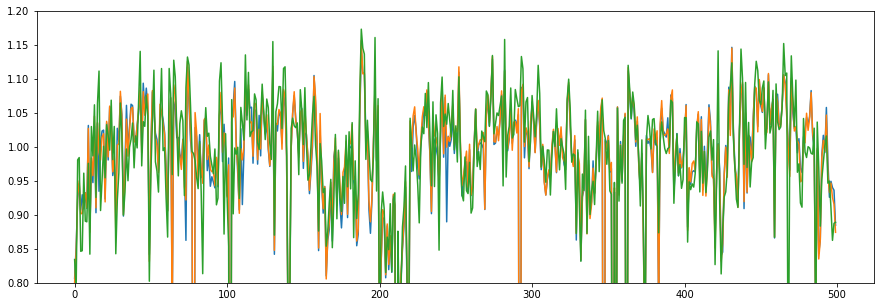

In [596]:
N = 1587 # Frame 345762
frames = [345762, 346350, 348345]

figure(figsize=(15,5))
collapsed = np.zeros((len(frames), 500))
for ix,frame in enumerate(frames):
    img = fits.getdata("/Users/npk/Downloads/spFlat-r1-%8.8i.fits" % frame)
    collapse = np.mean(img[:,900:3500],axis=1)
    plot(collapse)
    collapsed[ix] = collapse

    ylim(.8,1.2)

/var/folders/vm/_31_1nwj257bdljgsqfmnn7r0000gn/T/ipykernel_30124/2385032486.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plot(collapsed[2]/collapsed[0])
/var/folders/vm/_31_1nwj257bdljgsqfmnn7r0000gn/T/ipykernel_30124/2385032486.py:1: RuntimeWarning: invalid value encountered in true_divide
  plot(collapsed[2]/collapsed[0])


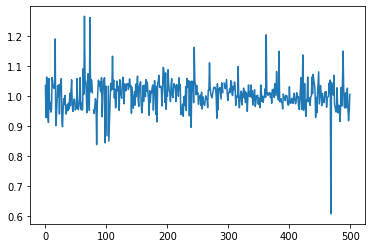

In [597]:
plot(collapsed[2]/collapsed[0])

What's up with:


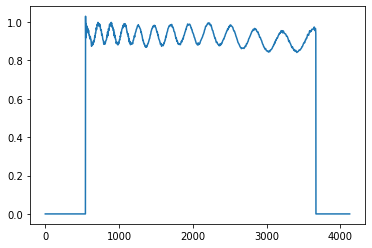

In [598]:
plot(img[255,])

# compute SD in a single flat

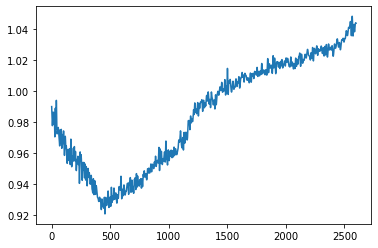

In [599]:
plot(img[256,900:3500])


/var/folders/vm/_31_1nwj257bdljgsqfmnn7r0000gn/T/ipykernel_30124/1867344541.py:4: RuntimeWarning: invalid value encountered in true_divide
  plot(y / np.median(y), '.')


(0.95, 1.05)

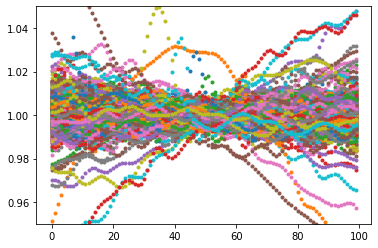

In [600]:
msds = np.zeros(500)
for ix, fl in enumerate(img):
    y = fl[1300:1400]
    plot(y / np.median(y), '.')
    msds[ix] = np.std(y)

ylim(.95,1.05)

/var/folders/vm/_31_1nwj257bdljgsqfmnn7r0000gn/T/ipykernel_30124/2536289249.py:1: RuntimeWarning: divide by zero encountered in true_divide
  semilogy(1/msds)


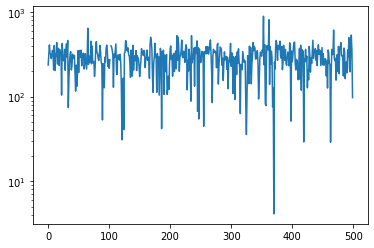

In [601]:
semilogy(1/msds)

In [602]:
np.std(img[256,1200:1300])

0.0051484667

(0.001, 0.1)

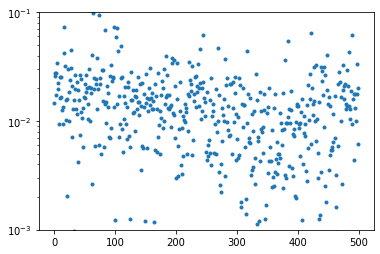

In [603]:
semilogy(np.std(collapsed,axis=0), '.')
ylim(0.001,.1)

In [604]:
np.mean(np.diff(tai))

38434.422120750889

In [605]:
np.diff(tai)[0:30]

array([  3.11100000e+03,   5.03100000e+03,   8.80890000e+04,
         1.00315300e+06,   5.97900000e+03,   3.40150000e+05,
         7.93800000e+03,   4.86700000e+03,   7.82000000e+03,
         1.71950000e+04,   9.58000001e+02,   4.78740000e+04,
         8.04700000e+03,   5.07400000e+03,   6.97000000e+03,
         6.93700000e+03,   6.98400000e+03,   5.13170000e+04,
         5.88400000e+03,   5.03900000e+03,   6.95700000e+03,
         7.61300000e+03,   8.14600000e+03,   6.31900000e+04,
         4.98500000e+03,   4.93300000e+03,   7.86200000e+03,
         5.87920000e+04,   4.97100000e+03,   8.04400000e+03])

Text(0.5, 1.0, 'Flat in fiber[255]/fiber[256] with simulated drop (BOSS Data)')

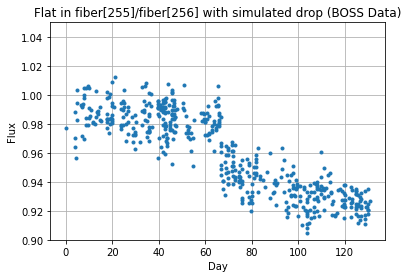

In [613]:
sl = slice(1000,1500)
#plot(mu[sl,250]/mu[sl,253])
drop = np.ones(sl.stop-sl.start)
drop[250:] = 1-60**2/330**2

xax = (tai[sl] - tai[sl][0])*1.157e-5 # second to day
vector = mu[sl,255]/mu[sl,256]
plot(xax, vector*drop, '.')
ylim(.9,1.05)
grid(True)
xlabel("Day")
ylabel("Flux")

title("Flat in fiber[255]/fiber[256] with simulated drop (BOSS Data)")


In [537]:
np.mean(vector)/np.std(vector)

44.706712539472285